In [1]:
import glob
import os
import csv
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from tabulate import tabulate
from astropy.table import Table
from astropy.io import ascii
from matplotlib.lines import Line2D
import matplotlib.ticker as tck
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import collections
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from astropy.cosmology import FlatLambdaCDM
from astroML.plotting import scatter_contour
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from extinction import fitzpatrick99
from astropy.visualization import make_lupton_rgb
from astropy.visualization import (MinMaxInterval, PercentileInterval, ImageNormalize, ZScaleInterval,simple_norm, LinearStretch, SqrtStretch, LogStretch, AsinhStretch)
cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
import matplotlib as mpl
mpl.rcParams['errorbar.capsize'] = 2
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams["font.family"] = "serif"

/home/raul/miniconda3/envs/py3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [3]:
fits.open('fit_outs/binned_nebular_specs_ESO113-32_MUSE.binned.lines.fits').info()

Filename: fit_outs/binned_nebular_specs_ESO113-32_MUSE.binned.lines.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      79   ()      
  1  FLUX          1 ImageHDU        51   (9724, 1, 41)   float64   
  2  EFLUX         1 ImageHDU        10   (9724, 1, 41)   float64   
  3  VEL           1 ImageHDU        10   (9724, 1, 41)   float64   
  4  EVEL          1 ImageHDU        10   (9724, 1, 41)   float64   
  5  LINEPARS      1 ImageHDU        10   (9724, 1, 123)   float64   
  6  ELINEPARS     1 ImageHDU        10   (9724, 1, 164)   float64   
  7  FLUXINT       1 ImageHDU        10   (9724, 1, 41)   float64   


In [2]:
PLANE1 = 'NII_6548.05'
PLANE2 = 'Halpha_6562.77'
PLANE3 = 'NII_6583.45'
PLANE10 = 'Hbeta_4861.33'
PLANE13 = 'OIII_5007'
PLANE20 = 'HeI_5875'
PLANE24 = 'OI_6300'
PLANE27 = 'SII_6716'
PLANE28 = 'SII_6731'


header = fits.open('fit_outs/binned_nebular_specs_NGC863_MUSE.binned.lines.fits')[1].header
header
plane_names = [PLANE1,PLANE2,PLANE3,PLANE10,PLANE13,PLANE20,PLANE24,PLANE27,PLANE28]
planes = [0, 1, 2, 9, 12, 19, 23, 26, 27]
wls = [6548.05, 6562.77, 6583.45, 4861.33, 5007, 5875, 6300, 6716, 6731]

galaxies = list(ascii.read('TABLE_MASTER_edge_on.tsv')['galaxy'])

In [11]:
galaxies

['NGC4666',
 'IC1657',
 'NGC259',
 'UGC11037',
 'UGC2936',
 'ESO297-G37',
 'ESO234-19',
 'NGC5690',
 'UGC11723',
 'UGC9450',
 'UGC8896',
 'ESO163-G11',
 'ESO443-21',
 'ESO113-32',
 'NGC3157',
 'ESO467-51',
 'IC1498',
 'IC719',
 'UGC10738']

In [29]:
bin_map = fits.open('seg_maps/seg_adabin_SNSII_10_NGC4666.fits')[0].data
int(np.max(bin_map)), 93508

(94949, 93508)

In [30]:
np.where(bin_map == 93507)

(array([230]), array([350]))

In [52]:
fits.open('/home/raul/Doctorado/BETISI/cubes/binned_ESO325-43.fits').info()

Filename: /home/raul/Doctorado/BETISI/cubes/binned_ESO325-43.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      53   (325, 325, 4444)   float64   
  1  ERRORES       1 ImageHDU        54   (325, 325, 4444)   float64   


In [45]:
fits.open('fit_outs/binned_nebular_specs_NGC4666.fits').info()

Filename: fit_outs/binned_nebular_specs_NGC4666.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      83   (94949, 1, 4701)   float64   
  1  ERRORES       1 ImageHDU        84   (94949, 1, 4701)   float64   


In [2]:
spec = fits.open('fit_outs/binned_nebular_specs_NGC4666.fits')[0].data[:,0,93507]
error = fits.open('fit_outs/binned_nebular_specs_NGC4666.fits')[1].data[:,0,93507]
hdr = fits.open('fit_outs/binned_nebular_specs_NGC4666.fits')[0].header

last_wavelength = hdr['CRVAL3'] + hdr['NAXIS3']
num_of_elements = int((last_wavelength -  hdr['CRVAL3']))
wavelength = np.linspace(hdr['CRVAL3'], last_wavelength, num_of_elements, endpoint=True)

#restframed_wavelength = wavelength
#number_of_wavelengths = np.floor(max(restframed_wavelength)) - np.ceil(min(restframed_wavelength))
#resampled_wavelength = np.arange(number_of_wavelengths) + np.ceil(restframed_wavelength[0])

spec_ = np.zeros((int(spec.shape[0]),1,1))
error_ = np.zeros((int(spec.shape[0]),1,1))

spec_[:,0,0] = spec
error_[:,0,0] = error

In [7]:
wavelength

array([4727.        , 4728.00021277, 4729.00042553, ..., 9425.99957447,
       9426.99978723, 9428.        ])

In [70]:
hdr['CDELT3']=1.0
hdr['CD3_3']=1.0
hdr['NAXIS3']=len(data_out)
hdr['CRVAL3'] = ini_model

In [71]:
hdu_flux=fits.PrimaryHDU(cubo,header=hdr)
hdu_error=fits.ImageHDU(error_,header=hdr,name='errores')
hdu_new=fits.HDUList([hdu_flux,hdu_error])
hdu_new.writeto('NGC4666_spec_prueba.fits', overwrite=True)

In [78]:
wavelength = list(ascii.read('NGC4666_bin_93507.BN', data_start=235)['col1'])
data_in = list(ascii.read('NGC4666_bin_93507.BN', data_start=235)['col2'])
data_out = list(ascii.read('NGC4666_bin_93507.BN', data_start=235)['col3'])

In [79]:
file_ = 'NGC4666_bin_93507.BN'

In [80]:
ini_model = int(list(ascii.read('NGC4666_bin_93507.BN', data_start=235)['col1'])[0])
end_model = int(list(ascii.read('NGC4666_bin_93507.BN', data_start=235)['col1'])[-1])

In [81]:
start_error = int(ascii.read('NGC4666_bin_93507.txt')['col1'][0])
end_error = int(ascii.read('NGC4666_bin_93507.txt')['col1'][-1])
error = list(ascii.read('NGC4666_bin_93507.txt')['col3'])
print(start_error, end_error)
print(ini_model, end_model)

4727 9304
4700 9100


In [101]:
if start_error >= ini_model:
    diff1 = start_error-ini_model
    error = [0] * diff + error
    start = 0
elif start_error < ini_model:
    start = ini_model - start_error
    
if end_error >= end_model:
    end = end_error - end_model
elif end_error < end_model:
    diff2 = end_model - end_error
    error =  error + [0] * diff 
    end = 0

In [102]:
diff2

14

In [86]:
ini_model, start_error, end_error, end_model = 4700, 4616, 9086, 9100

In [85]:
start, end

(0, 204)

In [84]:
len(error[start:-end])

4401

In [51]:
ini_model=int(ascii.read(file_, data_start=235)['col1'][0])

end_model=int(ascii.read(file_, data_start=235)['col1'][-1])

cubo = np.zeros((1 + end_model - ini_model, 1, 1))

In [52]:
end_model- ini_model, len(cubo)

(4400, 4401)

In [50]:
len((np.array(data_in)-np.array(data_out)))

4401

In [73]:
len(data_out)

4401

In [64]:
data_out = list(ascii.read(file_, data_start=235)['col3'])

data_in = list(ascii.read(file_, data_start=235)['col2'])



cubo[:,0,0]=(np.array(data_in)-np.array(data_out))*ascii.read(file_,data_start=16,data_end=17)['col1']


In [2]:
spec = fits.open('fit_outs/binned_nebular_specs_ESO113-32.fits')[0].data[:,0,4247]
error = fits.open('fit_outs/binned_nebular_specs_ESO113-32.fits')[1].data[:,0,4247]
hdr = fits.open('fit_outs/binned_nebular_specs_ESO113-32.fits')[0].header

last_wavelength = hdr['CRVAL3'] + hdr['NAXIS3']
num_of_elements = int((last_wavelength -  hdr['CRVAL3']))
wavelength = np.linspace(hdr['CRVAL3'], last_wavelength, num_of_elements, endpoint=True)

spec_ = np.zeros((int(spec.shape[0]),1,1))
error_ = np.zeros((int(spec.shape[0]),1,1))

spec_[:,0,0] = spec
error_[:,0,0] = error

#hdu_flux=fits.PrimaryHDU(spec_,header=hdr)
#hdu_error=fits.ImageHDU(error_,header=hdr,name='errores')
#hdu_new=fits.HDUList([hdu_flux,hdu_error])
#hdu_new.writeto('ESO113-32_spec_prueba.fits', overwrite=True)

In [18]:
np.where(fits.open('seg_maps/seg_adabin_SNSII_10_NGC259.fits')[0].data==2041)

(array([128, 128, 128, 128, 129, 129, 129, 129, 130, 130, 130, 130, 131,
        131, 131, 131]),
 array([184, 185, 186, 187, 184, 185, 186, 187, 184, 185, 186, 187, 184,
        185, 186, 187]))

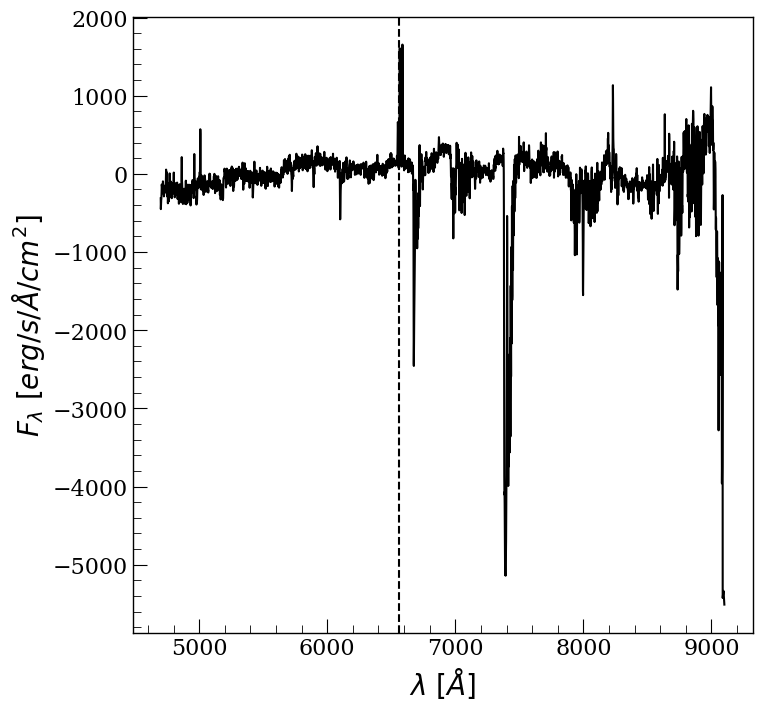

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

ax.minorticks_on()


#ax.plot(wavelength, data_in*ascii.read(file_,data_start=16,data_end=17)['col1'],color='royalblue')
#ax.plot(wavelength, data_out*ascii.read(file_,data_start=16,data_end=17)['col1'],color='red')
ax.plot(wavelength, spec ,color='black')

wl_line =  6563

#wl_line =  6300

#ax.set_ylim (-5000, 18000)

#ax.set_title(labels[k], fontsize=20)

ax.set_xlabel('$\lambda$ $[\AA]$', fontsize=20)
ax.set_ylabel('$F_{\lambda}$ $[erg/s/\AA/cm^2]$', fontsize=20)

ax.tick_params(which='minor', size=6, direction='in', labelsize=16)
ax.tick_params(which='major', size=10, direction='in', labelsize=16)


#ax.set_xlim(wl_line-165,wl_line+165)

ax.axvline(x = wl_line, linestyle='dashed', c='black')

#plt.savefig('EWs_spectra_4_HeI',bbox_inches='tight',format='eps',dpi=1000)

plt.show()

# <font color='blue'>Lines</font>

In [3]:
#galaxies = ['ESO157-49']
for gal in galaxies:
    print(gal)
    bin_map = fits.open('seg_maps/seg_adabin_SNSII_10_'+gal+'.fits')[0].data
    
    line_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_line_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    vel_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    i_plane = 0
    
    for plane in planes:
        flux = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[1].data[plane]
        e_flux = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[2].data[plane]
        vel = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[3].data[plane]#[5].data[3*plane+2]*299792.458/wls[i_plane]
        e_vel = fits.open('fit_outs/ALT_binned_nebular_specs_'+gal+'_MUSE.binned.lines.fits')[4].data[plane]#[6].data[3*plane+2]*299792.458/wls[i_plane]
        
        for bin_index in range(0, int(np.max(bin_map))):
            coords = np.where(bin_map == bin_index)
            x, y = list(coords[0]), list(coords[1])
            for i,j in zip(x,y):    
           #     line_map[int(i),int(j)] = flux[0, bin_index]
           #     e_line_map[int(i),int(j)] = e_flux[0, bin_index]/2
                vel_map[int(i),int(j)] = vel[0, bin_index]
                e_map[int(i),int(j)] = e_vel[0, bin_index]/2
        
     #   hdu_flux = fits.PrimaryHDU(line_map)
     #   hdu_error = fits.ImageHDU(e_line_map ,name='errores')
     #   hdu_new = fits.HDUList([hdu_flux, hdu_error])
     #   hdu_new.writeto('line_maps/binned_flux_' +gal+'_'+plane_names[i_plane] + '_2.fits', overwrite=True)
        
        hdu_vel = fits.PrimaryHDU(vel_map)
        hdu_e_vel = fits.ImageHDU(e_map ,name='errores')
        hdu_new = fits.HDUList([hdu_vel, hdu_e_vel])
        hdu_new.writeto('vel_maps/binned_vel_' + gal+'_'+plane_names[i_plane] + '.fits', overwrite=True)
        i_plane=i_plane+1


IC217
PGC28308
PGC30591
ESO544-27
IC1553
ESO443-21
ESO469-15
ESO157-49


In [19]:
def divide_flux(seg_map, maps):

    for i in range(1,int(np.max(seg_map)+1)):
        x_ = np.where(seg_map==i)[0]
        y_ = np.where(seg_map==i)[1]
        if len(x_)>0:
            maps[x_,y_] = maps[x_,y_] / np.sqrt(len(x_))
    return maps

def split_list(alist, wanted_parts = 1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

#galaxies = ascii.read('edge_on_2')['galaxy']

for gal in galaxies:
    print(gal)
    seg_map = fits.open('seg_maps/seg_adabin_SNSII_10_'+gal+'.fits')[0].data

  #  Hamap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE2+'_2.fits')[0].data * 1e-20
  #  OIIImap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE13+'.fits')[0].data * 1e-20
  #  NIImap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE3+'.fits')[0].data * 1e-20
    OImap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE24+'_2.fits')[1].data * 1e-20
  #  Hbmap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE10+'.fits')[0].data * 1e-20
  #  SIImap_16 = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE27+'.fits')[0].data * 1e-20
  #  SIImap_31 = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE28+'.fits')[0].data * 1e-20
  #  HeImap = fits.open('line_maps/binned_flux_'+gal+'_'+PLANE20+'.fits')[0].data * 1e-20
    
  #  Hamap = divide_flux(seg_map, Hamap)
  #  OIIImap = divide_flux(seg_map, OIIImap)
  #  NIImap = divide_flux(seg_map, NIImap)
    OImap = divide_flux(seg_map, OImap)
  #  Hbmap = divide_flux(seg_map, Hbmap)
  #  SIImap_16 = divide_flux(seg_map, SIImap_16)
  #  SIImap_31 = divide_flux(seg_map, SIImap_31)
  #  HeImap = divide_flux(seg_map, HeImap)
    
  #  hdur = fits.PrimaryHDU(Hamap)
  #  hdur.writeto('divided_maps/'+gal+'_divided_Ha_2.fits', overwrite=True)
    
  # hdur = fits.PrimaryHDU(OIIImap)
  # hdur.writeto('divided_maps/'+gal+'_divided_OIII.fits', overwrite=True)
  # 
  # hdur = fits.PrimaryHDU(NIImap)
  # hdur.writeto('divided_maps/'+gal+'_divided_NII.fits', overwrite=True)
  # 
    hdur = fits.PrimaryHDU(OImap)
    hdur.writeto('divided_maps/'+gal+'_divided_OI_error.fits', overwrite=True)
  # 
  # hdur = fits.PrimaryHDU(Hbmap)
  # hdur.writeto('divided_maps/'+gal+'_divided_Hb.fits', overwrite=True)
  # 
  # hdur = fits.PrimaryHDU(SIImap_16)
  # hdur.writeto('divided_maps/'+gal+'_divided_SII_16.fits', overwrite=True)
  # 
  # hdur = fits.PrimaryHDU(SIImap_31)
  # hdur.writeto('divided_maps/'+gal+'_divided_SII_31.fits', overwrite=True)
  # 
  # hdur = fits.PrimaryHDU(HeImap)
  # hdur.writeto('divided_maps/'+gal+'_divided_HeI.fits', overwrite=True)

ESO443-21


# <font color='green'>EWs</font>

In [7]:
for gal in galaxies:
    print(gal)

    bin_map = fits.open('seg_maps/seg_adabin_SNSII_10_'+gal+'.fits')[0].data
    
    EW_Ha_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_EW_Ha_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    EW_Hb_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
    e_EW_Hb_map = np.zeros((bin_map.shape[0], bin_map.shape[1]))
        
    EW_Ha = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[2].data[0]
    e_EW_Ha = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[3].data[0]
    EW_Hb = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[2].data[1]
    e_EW_Hb = fits.open('/home/raul/Doctorado/BETISII/fit_outs/ALT_binned_stellar_specs_'+gal+'_MUSE.EWs.binned.fits')[3].data[1]
    
    for bin_index in range(0, int(np.max(bin_map))):
        coords = np.where(bin_map == bin_index)
        x, y = list(coords[0]), list(coords[1])
        for i,j in zip(x,y):    
            EW_Ha_map[int(i),int(j)] = EW_Ha[0, bin_index]
            e_EW_Ha_map[int(i),int(j)] = e_EW_Ha[0, bin_index]/2
            EW_Hb_map[int(i),int(j)] = EW_Hb[0, bin_index]
            e_EW_Hb_map[int(i),int(j)] = e_EW_Hb[0, bin_index]/2
    
    hdu_flux = fits.PrimaryHDU(EW_Ha_map)
    hdu_error = fits.ImageHDU(e_EW_Ha_map ,name='errores')
    hdu_new = fits.HDUList([hdu_flux, hdu_error])
    hdu_new.writeto('EW_maps/binned_EW_Ha_' +gal+'.fits', overwrite=True)
    
    hdu_flux = fits.PrimaryHDU(EW_Hb_map)
    hdu_error = fits.ImageHDU(e_EW_Hb_map ,name='errores')
    hdu_new = fits.HDUList([hdu_flux, hdu_error])
    hdu_new.writeto('EW_maps/binned_EW_Hb_' +gal+'.fits', overwrite=True)

UGC8896
ESO163-G11
ESO443-21
ESO113-32
NGC3157
ESO467-51
IC1498
IC719
UGC10738
NGC4666
IC1657
NGC259
UGC11037
UGC2936
ESO297-G37
ESO234-19
NGC5690
UGC11723
UGC9450


# <font color='red'>Plots</font>

In [97]:
ha_map_og = fits.open('/media/raul/Datos/Doctorado/BETISI/line_maps/binned_NGC863_MUSE.binned.lines.fits')[2].data[1]

<IPython.core.display.Javascript object>


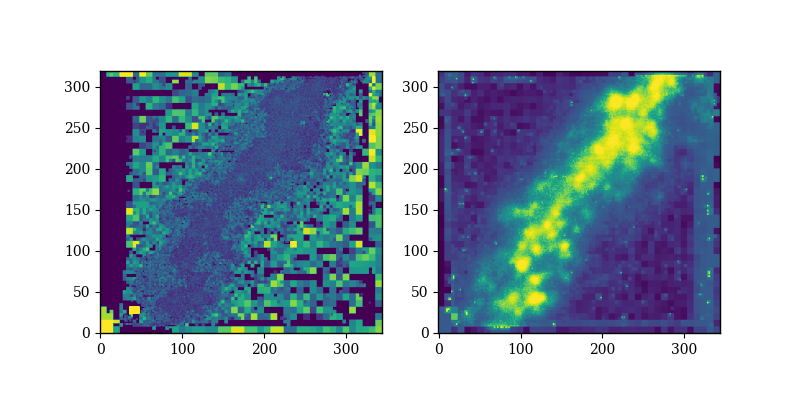

In [98]:
%matplotlib notebook

fig, (ax, ax2) = plt.subplots(1, 2, figsize = (8,4))

Interval=PercentileInterval(98.5)


norm = ImageNormalize(ha_map,Interval,stretch=SqrtStretch())

ax.imshow(ha_map ,origin='lower',norm=norm)

norm2 = ImageNormalize(bin_map,Interval,stretch=SqrtStretch())

ax2.imshow(bin_map ,origin='lower',norm=norm2)

plt.show()

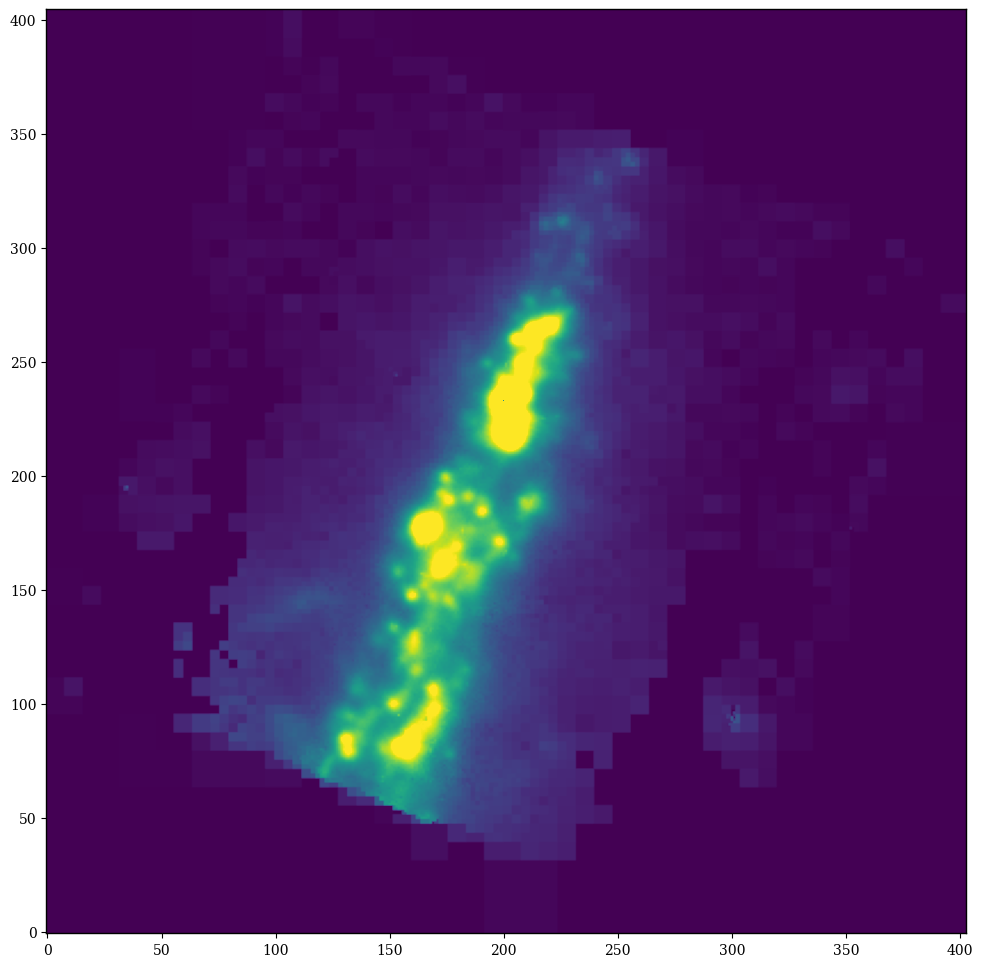

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (12,12))

Interval=PercentileInterval(98.5)

#gals = list(ascii.read('edge_on_1')['galaxy'][1:]) + list(ascii.read('edge_on_2')['galaxy'])

for gal in galaxies:

    ha_map = fits.open('divided_maps/'+gal+'_divided_Ha_2.fits')[0].data
   # SN_map = fits.open('sn_maps/'+gal+'_SN_Ha_binned_map.fits')[0].data
   # SN_map[SN_map<2.5]=0
    #SN_map = SN_map/SN_map
    norm = ImageNormalize(ha_map,Interval,stretch=SqrtStretch())
    
    ax.imshow(ha_map ,origin='lower',norm=norm)
    
   # plt.savefig('plots/'+gal+'_Ha_binned_map.jpg', bbox_inches='tight')

In [17]:
SN_map = fits.open('sn_maps/'+gal+'_SN_SII_binned_map.fits')[0].data
SN_map[SN_map<3]==0
SN_map=SN_map/SN_map
SN_map

array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [77]:
coc = ha_map/ha_map_og

coc = coc[np.isinf(coc)== 0.]

/tmp/ipykernel_6307/3483659537.py:1: RuntimeWarning: divide by zero encountered in divide
  coc = ha_map/ha_map_og
/tmp/ipykernel_6307/3483659537.py:1: RuntimeWarning: invalid value encountered in divide
  coc = ha_map/ha_map_og


In [78]:
np.nanmedian(coc)

0.23658603462773523